In [371]:
from __future__ import division
import pandas as pd
import numpy as np 
import matplotlib.pylab as plt
import seaborn as sns

from code.organize import *
from code.roughEDA import *
from code.survey_processor_full import *
from code.model_vis import *
from code.fc import *
from code.fc_cluster import *
from collections import Counter,defaultdict,OrderedDict

from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix,roc_curve
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

from treeinterpreter import treeinterpreter as ti
import matplotlib.cm as cm
import cPickle as pickle
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Feature Contribution Analysis

In this session, how does each feature contribute to random forest decision making will be analysed. 
## 1. Load feature contribution matrix and group by cluster id

In [2]:
fc = FeatureContribution('data/fc_df2.pkl')
fc_df = fc.cluster_processor(3,6)

In [3]:
summary = fc_df.groupby('cluster')['employed'].agg([np.mean,np.size])
summary.columns = ['employment_rate','sample_size']
summary

,employment_rate,sample_size
cluster,,
0,0.924484,2132
1,0.082192,365
2,0.040498,642
3,0.900459,653
4,0.895753,259
5,0.059809,418


**Cluster 1,2,5** are unemployed groups. **Cluster 0,3,4** are employed groups. 


## 2.  Load original survey data

In [4]:
sv = survey('data/survey2')
sv.num_processor()

In [6]:
df = pd.concat([sv.fin_data[sv.num_cols],sv.data[sv.sv_cols],sv.fin_data.employed],axis =1)

f40 = fc_df.columns[:41]
df40= df[f40]
l = list(df40.columns)
l.append('cluster')

new = np.column_stack((df40.values,fc_df.cluster))
df = pd.DataFrame(new,columns=l)

### Group by cluster. Take medians for numeric variables. Take mode for categorical variables.

**Numeric variables**

In [7]:
df[sv.num_cols] = df[sv.num_cols].astype('float')

In [8]:
df_num = df.groupby('cluster')[sv.num_cols].agg([np.median])

In [9]:
df_num

,sphrs1,age,agekdbrn,chldidel,coninc,educom
,median,median,median,median,median,median
cluster,,,,,,
0,60.0,36,25,4.0,49882.50,12.333333
1,98.0,31,19,5.0,8617.50,12.000000
2,54.5,35,25,8.0,52811.00,12.666667
3,98.0,33,21,4.0,9033.75,12.333333
4,98.0,34,19,4.0,18745.00,11.666667
5,98.0,34,22,6.5,7124.00,12.333333


BS ratio: 0.50123070038
BS number: 2240


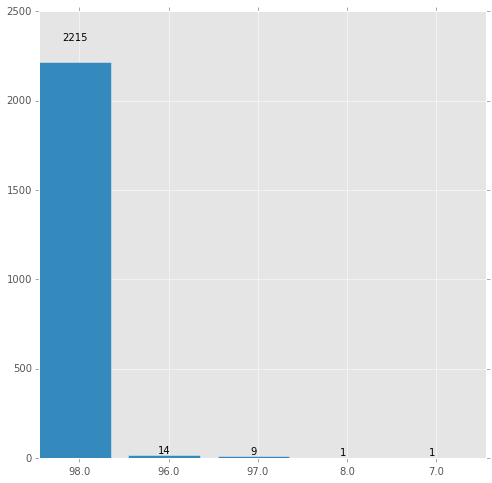

In [10]:
check_bs(df.sphrs1,sv.bs_flag)

BS ratio: 0.479973148355
BS number: 2145


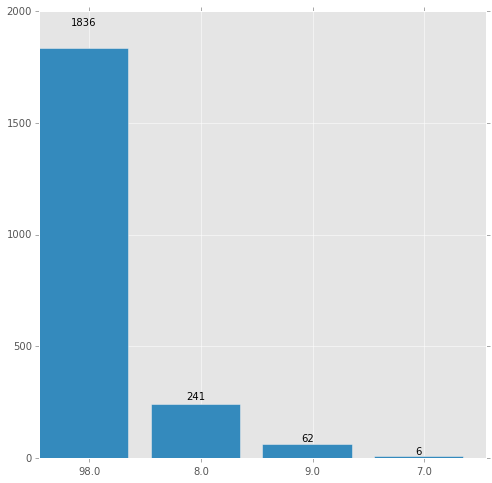

In [11]:
check_bs(df.chldidel,sv.bs_flag)

About half respondents did not answer spouse working hours or ideal number of kids. It's not accurate to take mean or median without removing the flag. Thereby, I'll remove respondents who didn't answer these two questions, then take median values. 

Age, agekdbrn and coninc maintain the median values. Educom uses mean because it further split the clusters. 

In [193]:
df_n = df_num(df)

In [194]:
df_n

,sphrs1,chldidel,age,agekdbrn,coninc,educom
cluster,,,,,,
0,42,2.0,36,25,49882.50,12.62
1,40,3.0,31,19,8617.50,10.80
2,50,2.5,35,25,52811.00,12.94
3,40,2.0,33,21,9033.75,12.28
4,40,3.0,34,19,18745.00,10.44
5,40,3.0,34,22,7124.00,12.08


**Categorical variables**

In [170]:
cat_cols = list(set(df.columns) - set(sv.num_cols) - set(['cluster']))

Lots of "Not applicable" in mode answers. Use secondary mode answer instead if "not applicable" shows up.

In [199]:
df_cat = df.groupby('cluster')[cat_cols].agg([mode_answer,percent])

In [203]:
df_cat_a = df_cat.iloc[:,0::2]
df_cat_a.columns = cat_cols

In [204]:
df_summary = pd.concat([df_n,df_cat_a],axis =1)

In [207]:
df_summary.sort('employed').T

/Users/yleng/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


cluster,1,2,5,0,3,4
sphrs1,40,50,40,42,40,40
chldidel,3,2.5,3,2,2,3
age,31,35,34,36,33,34
agekdbrn,19,25,22,25,21,19
coninc,8617.5,52811,7124,49882.5,9033.75,18745
educom,10.8,12.94,12.08,12.62,12.28,10.44
affrmact,Oppose pref,Strongly oppose pref,Strongly oppose pref,Strongly oppose pref,Strongly oppose pref,Strongly oppose pref
fechld,Agree,Agree,Agree,Strongly agree,Agree,Strongly agree
helpnot,Agree with both,Agree with both,Agree with both,Agree with both,Agree with both,Agree with both
spanking,Agree,Agree,Agree,Agree,Agree,Agree


### Generate a heatmap

In [268]:
heat_df = pd.concat([sv.fin_data[sv.num_cols],sv.fin_data[sv.sv_cols],sv.fin_data.employed],axis =1)

f40 = fc_df.columns[:41]
heat_df40= heat_df[f40]
l = list(heat_df40.columns)
l.append('cluster')

new = np.column_stack((heat_df40.values,fc_df.cluster))
heat_df = pd.DataFrame(new,columns=l)

In [269]:
heat_df_n = df_num(heat_df)
heat_df_cat = heat_df.groupby('cluster')[cat_cols].agg([mode_answer])
heat_df_cat.columns = cat_cols
heat_df_sum = pd.concat([heat_df_n,heat_df_cat],axis =1)

In [274]:
from sklearn.preprocessing import scale
heat_df_sum[cat_cols] = heat_df_sum[cat_cols].apply(lambda x: x.astype('int'))
heat_df_sum[sv.num_cols] = scale(heat_df_sum[sv.num_cols])
heat_df_sum.sort('employed',inplace=True)

/Users/yleng/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


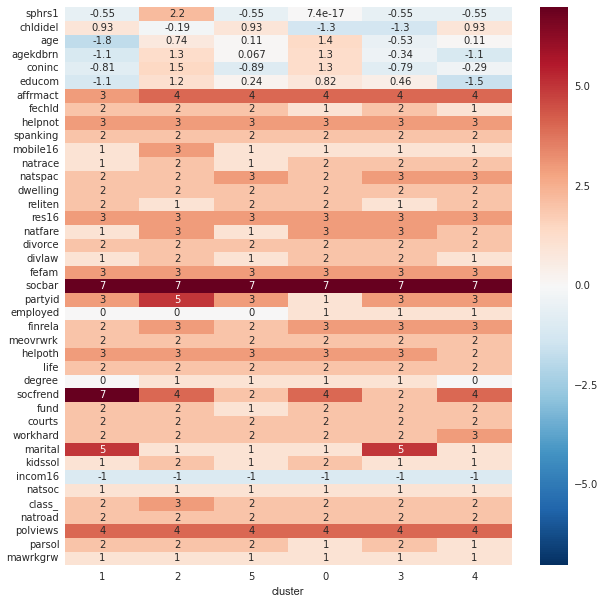

In [291]:
plt.figure(figsize=(10,10))
sns.heatmap(heat_df_sum.T,annot=True)

To distinguish clusters, we need to drop the features have the same values across clusters. 

In [333]:
redu_heat_df = drop_feature(heat_df_sum).T
redu_heat_df = redu_heat_df.reindex(['sphrs1','chldidel','age','agekdbrn','coninc','educom','affrmact',
                                     'fechld','mobile16','natrace','natspac', 'reliten', 'natfare','divlaw',
                                      'partyid', 'finrela', 'helpoth', 'degree','socfrend', 'fund', 'workhard',
                                     'marital', 'kidssol', 'class_', 'parsol','employed'])

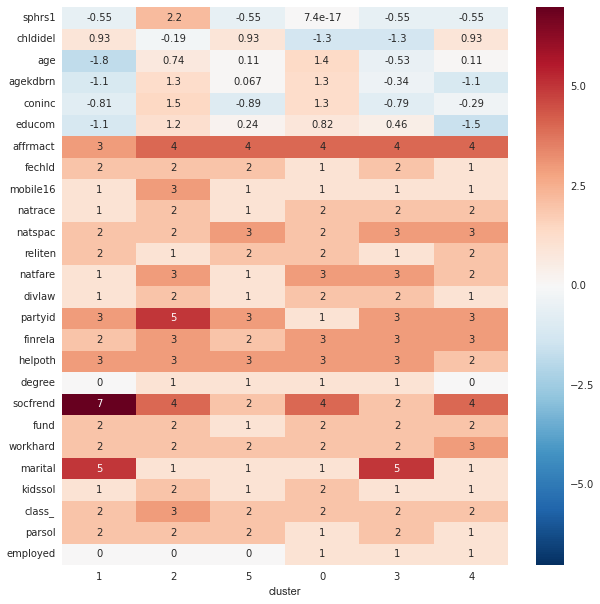

In [334]:
plt.figure(figsize=(10,10))
sns.heatmap(redu_heat_df,annot=True)

Now it is easier to check. 
## to do :check cose similiarities. 

## 3. Unemployed Clusters

In [418]:
unemp_heat = redu_heat_df[redu_heat_df.columns[:3]]

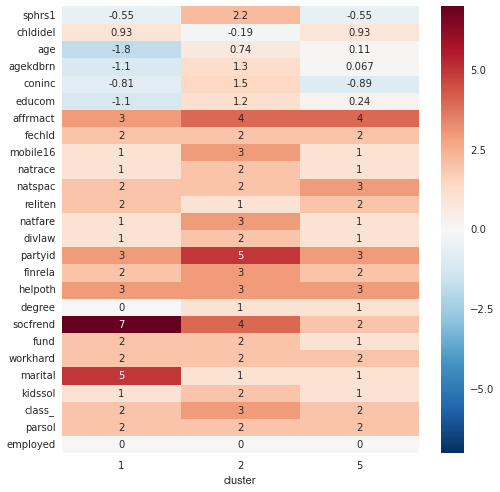

In [419]:
plt.figure(figsize=(8,8))
sns.heatmap(unemp_heat,annot=True)

### Cluster 1

In [397]:
c1 = fc_df[fc_df.cluster == 1]

These features are the top 10 features driving the decision.

In [398]:
sort_feature_means(c1,10)

[(-0.12551662685679615, 'degree'),
 (-0.063086126768045356, 'coninc'),
 (-0.021723891743851996, 'age'),
 (-0.017084660320522339, 'agekdbrn'),
 (-0.016895788647500305, 'educom'),
 (-0.014650047797046557, 'class_'),
 (-0.011659304310631145, 'polviews'),
 (-0.010897973232229251, 'incom16'),
 (-0.010461340957816267, 'dwelling'),
 (-0.0095513131604080034, 'socfrend')]

#### Details in their answers

In [399]:
df_c1 = df[df.cluster ==1]

In [400]:
df_summary[redu_heat_df.index].ix[1]

sphrs1                   40
chldidel                  3
age                      31
agekdbrn                 19
coninc               8617.5
educom                 10.8
affrmact        Oppose pref
fechld                Agree
mobile16          Same city
natrace          Too little
natspac         About right
reliten     Not very strong
natfare          Too little
divlaw               Easier
partyid         Independent
finrela       Below average
helpoth       3rd important
degree       Lt high school
socfrend              Never
fund               Moderate
workhard      2nd important
marital       Never married
kidssol         Much better
class_        Working class
parsol      Somewhat better
employed              False
Name: 1, dtype: object

### population dwelling

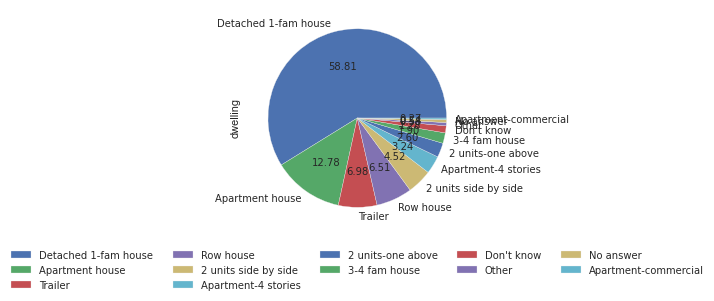

In [450]:
simple_pie(df.dwelling,(4,4))

### cluster 1 dwelling

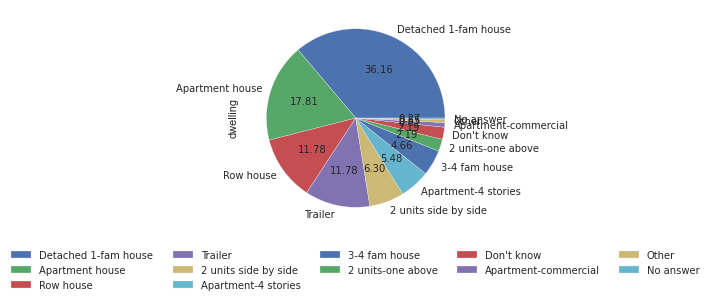

In [408]:
simple_pie(df_c1.dwelling,(4,4))

### cluster 1 spend evening with friends

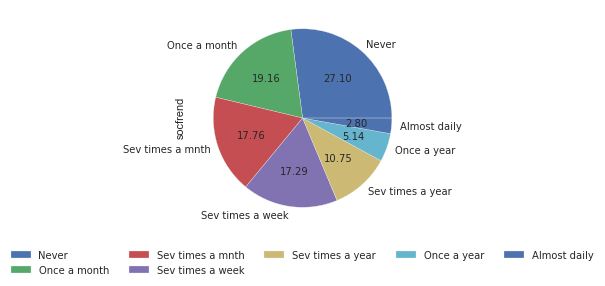

In [451]:
simple_pie(df_c1.socfrend.replace(sv.bs,np.nan),(4,4))

## population spend evenings with friends

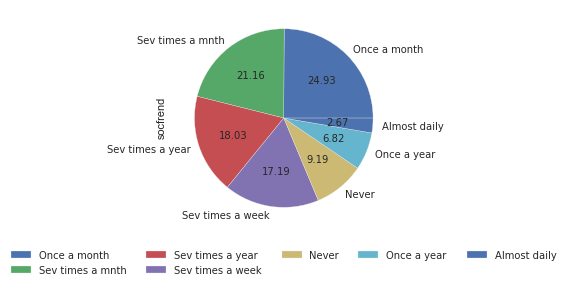

In [452]:
simple_pie(df.socfrend.replace(sv.bs,np.nan),(4,4))

## population political views

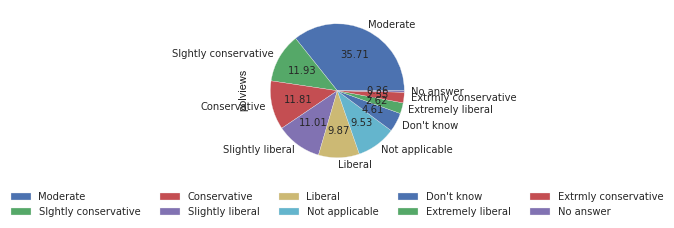

In [425]:
simple_pie(df.polviews,(3,3))

### cluster1 political views

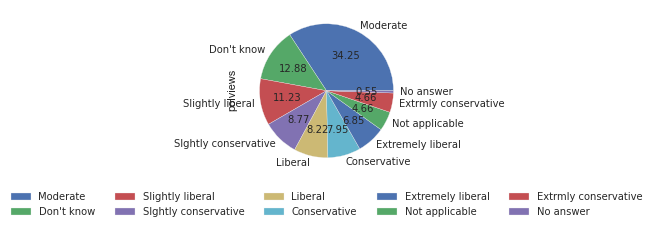

In [427]:
simple_pie(df_c1.polviews,(3,3))

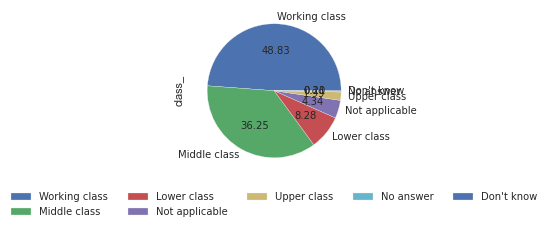

In [441]:
#population class_
simple_pie(df.class_,(3,3))

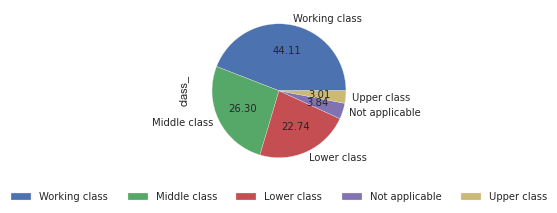

In [442]:
#cluster 1 class_
simple_pie(df_c1.class_,(3,3))

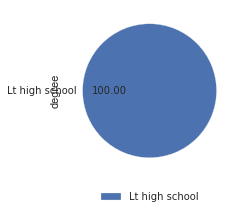

In [444]:
## Cluster 1 Degree
simple_pie(df_c1.degree,(3,3))

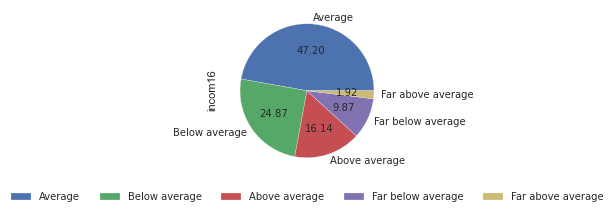

In [448]:
## population income 16
simple_pie(df.incom16.replace(sv.bs,np.nan),(3,3))

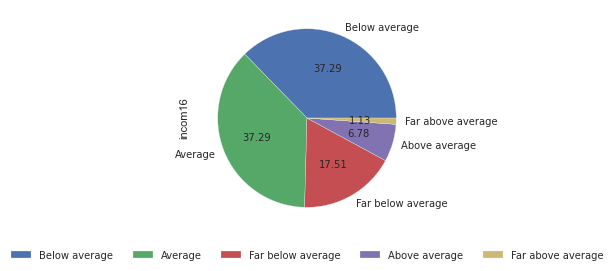

In [449]:
# cluster 1 income 16
simple_pie(df_c1.incom16.replace(sv.bs,np.nan),(4,4))

## Women in cluster 1 have following characteristics:
  * They don't have high degree. all of them have less than high school degree. **Main decision driver**
  * Their median age of giving birth to their first child is 19, way lower than the entire population (23)
  * Their median family income is below population median and they consider their finanicial situations are below average. More of them consider themselve lower class than population. 
  * They grow up in poor families. More of them responded their family income when they're 16 are below or far below average.
  * When asking their political views, the proportion of "don't know" is higher than the public.
  * most of them answer they never spend evening with friends.
  
  ### Summary: They have children early, less educated, from less educated family and living in poor conditions.


### Cluster 2

In [453]:
c2 = fc_df[fc_df.cluster ==2]

Top 10 driving features

In [454]:
sort_feature_means(c2,10)

[(-0.034108965757154275, 'age'),
 (-0.032352318019756555, 'educom'),
 (-0.029752545104176506, 'sphrs1'),
 (-0.02332004490984585, 'agekdbrn'),
 (-0.018308817158882766, 'partyid'),
 (-0.016054668892952786, 'divorce'),
 (-0.015780474788718659, 'polviews'),
 (-0.015230611110697389, 'res16'),
 (-0.014822270722593071, 'incom16'),
 (-0.013142176042391294, 'reliten')]

In [456]:
df_c2 = df[df.cluster ==2]

In [458]:
df_summary[redu_heat_df.index].ix[2]

sphrs1                        50
chldidel                     2.5
age                           35
agekdbrn                      25
coninc                     52811
educom                     12.94
affrmact    Strongly oppose pref
fechld                     Agree
mobile16         Different state
natrace              About right
natspac              About right
reliten                   Strong
natfare                 Too much
divlaw            More difficult
partyid       Not str republican
finrela                  Average
helpoth            3rd important
degree               High school
socfrend            Once a month
fund                    Moderate
workhard           2nd important
marital                  Married
kidssol          Somewhat better
class_              Middle class
parsol           Somewhat better
employed                   False
Name: 2, dtype: object

In [23]:
cluster_summary(df_c1,cat_cols)

,rank_first,rank_second
fechld,"(Not applicable, 0.43)","(Agree, 0.25)"
natrace,"(Not applicable, 0.54)","(About right, 0.2)"
socfrend,"(Not applicable, 0.44)","(Once a month, 0.14)"
reliten,"(Strong, 0.45)","(Not very strong, 0.31)"
res16,"(Town lt 50000, 0.29)","(50000 to 250000, 0.21)"
divorce,"(No, 0.73)","(Not applicable, 0.14)"
polviews,"(Moderate, 0.34)","(Conservative, 0.14)"
fefam,"(Not applicable, 0.43)","(Disagree, 0.25)"
socbar,"(Not applicable, 0.44)","(Never, 0.29)"
partyid,"(Not str democrat, 0.19)","(Not str republican, 0.18)"


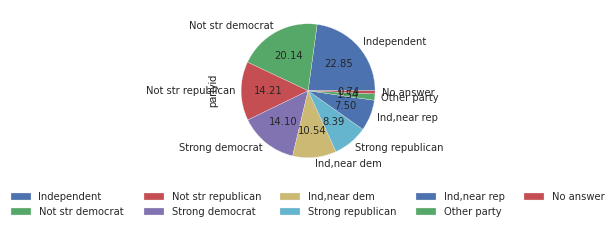

In [461]:
## population party id
simple_pie(df.partyid,(3,3))

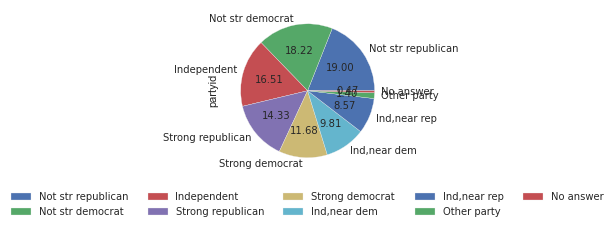

In [463]:
## cluster 2 party id
simple_pie(df_c2.partyid,(3,3))

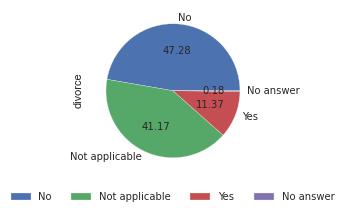

In [466]:
# population divorce
simple_pie(df.divorce,(3,3))

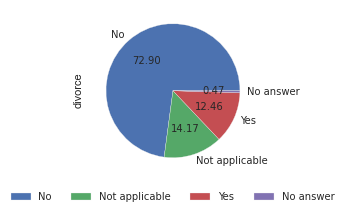

In [467]:
## cluster 2 divorce
simple_pie(df_c2.divorce,(3,3))

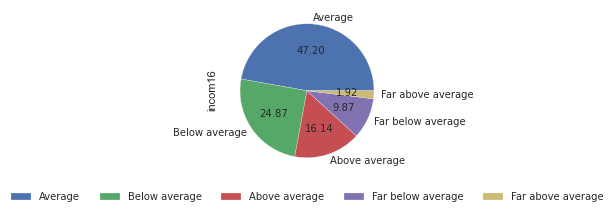

In [473]:
# population income 16
simple_pie(df.incom16.replace(sv.bs,np.nan),(3,3))

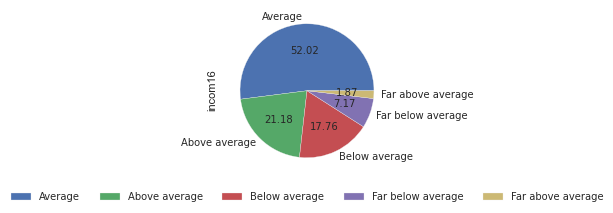

In [474]:
## cluster 2 income 16
simple_pie(df_c2.incom16.replace(sv.bs,np.nan),(3,3))

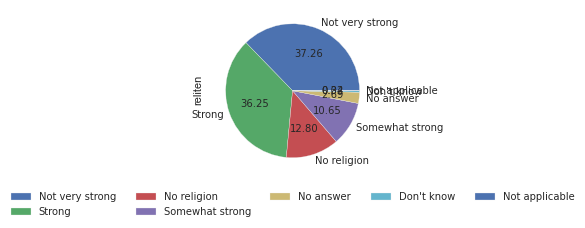

In [475]:
# population resliten
simple_pie(df.reliten,(3,3))

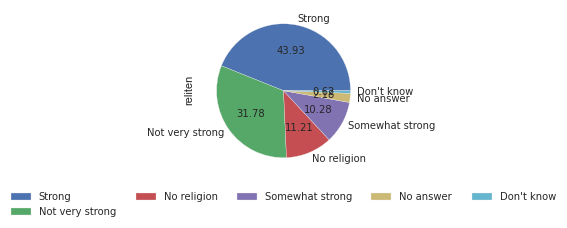

In [476]:
# cluster 2 resliten
simple_pie(df_c2.reliten,(3,3))

### Women in cluster 2 have flowing characteristics:
  * Their husbands work longer than population. Their median family incomes are higher than population.
  * They have high shool or college degrees and their family members' education years are also longer than the public.
  * Their most voted partid is "not strong republican", more conservative political views and strong affiliation to religions.
  * majority of them never divorced.
  * The more of them grow up in a family whose income are above average.
  
  ## summary: Women in this cluster grow up in rich family and currently living in a rich family. They are well educated and conservative. 

## Cluster 4

In [539]:
c4 = fc_df[fc_df.cluster ==4]

In [540]:
sort_feature_means(c4,10)

[(-0.112494637432098, 'degree'),
 (0.023824348249125188, 'coninc'),
 (0.019713158066941121, 'age'),
 (0.012102558777930487, 'educom'),
 (0.011566590279362654, 'dwelling'),
 (0.011441392099877318, 'agekdbrn'),
 (0.010129008147363151, 'incom16'),
 (0.010116250691920407, 'polviews'),
 (0.010062968834124908, 'partyid'),
 (0.0095081045009339886, 'res16')]

In [481]:
df_c5 = df[df.cluster ==5]

In [482]:
df_summary[redu_heat_df.index].ix[5]

sphrs1                        40
chldidel                       3
age                           34
agekdbrn                      22
coninc                      7124
educom                     12.08
affrmact    Strongly oppose pref
fechld                     Agree
mobile16               Same city
natrace               Too little
natspac                 Too much
reliten          Not very strong
natfare               Too little
divlaw                    Easier
partyid              Independent
finrela            Below average
helpoth            3rd important
degree               High school
socfrend        Sev times a week
fund              Fundamentalist
workhard           2nd important
marital                  Married
kidssol              Much better
class_             Working class
parsol           Somewhat better
employed                   False
Name: 5, dtype: object

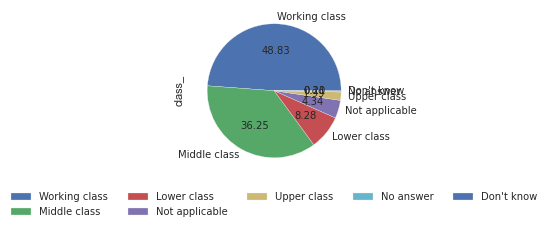

In [480]:
## population class
simple_pie(df.class_,(3,3))

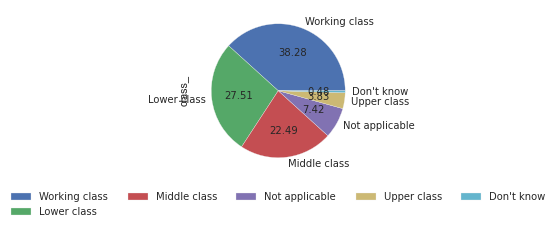

In [483]:
## cluster 5 class
simple_pie(df_c5.class_,(3,3))

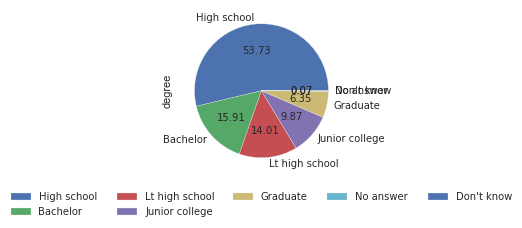

In [484]:
#population degree
simple_pie(df.degree,(3,3))

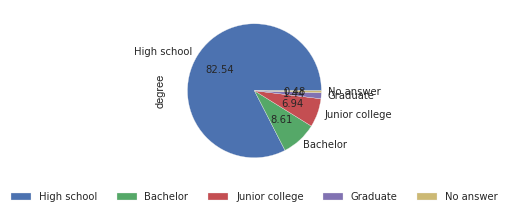

In [485]:
# cluster 5 degree
simple_pie(df_c5.degree,(3,3))

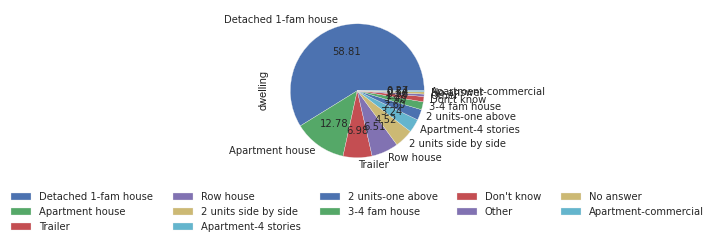

In [492]:
#population dwelling
simple_pie(df.dwelling,(3,3))

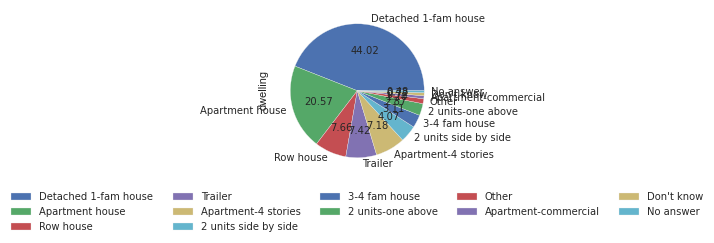

In [493]:
#cluster 5 dwelling
simple_pie(df_c5.dwelling,(3,3))

### Women in cluster 5 have flowing characteristics:
  * They are from poor family. Their median family income are below that in population median.
  * They consider themselves are in working class or lower class. They think their family income is below average. 
  * They and their family don't have higher education. About high school degree. 
  * More of them living in apartment houses.
  * They are not religous
  
  ### summary: sort of in between cluster 1 and 2

## 4. Employed Class

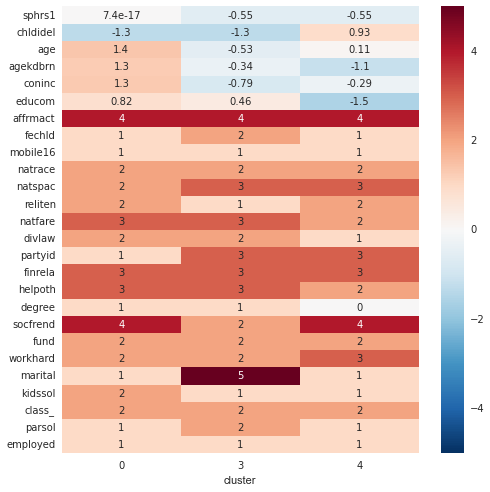

In [498]:
plt.figure(figsize=(8,8))
sns.heatmap(redu_heat_df[redu_heat_df.columns[3:]],annot=True)

### Cluster 0

In [499]:
c0 = fc_df[fc_df.cluster ==0]

In [500]:
sort_feature_means(c0,10)

[(0.042080973391574079, 'coninc'),
 (0.021046270006271194, 'degree'),
 (0.01324399045827203, 'age'),
 (0.010083204302881267, 'educom'),
 (0.0092835604906183634, 'agekdbrn'),
 (0.0076032508735443816, 'sphrs1'),
 (0.0065322028558504911, 'class_'),
 (0.0065133198555721722, 'polviews'),
 (0.0061523862357446696, 'partyid'),
 (0.0056848289513118048, 'finrela')]

In [505]:
df_c0 = df[df.cluster==0]

In [504]:
df_summary[redu_heat_df.index].ix[0]

sphrs1                        42
chldidel                       2
age                           36
agekdbrn                      25
coninc                   49882.5
educom                     12.62
affrmact    Strongly oppose pref
fechld            Strongly agree
mobile16               Same city
natrace              About right
natspac              About right
reliten          Not very strong
natfare                 Too much
divlaw            More difficult
partyid         Not str democrat
finrela                  Average
helpoth            3rd important
degree               High school
socfrend            Once a month
fund                    Moderate
workhard           2nd important
marital                  Married
kidssol          Somewhat better
class_             Working class
parsol               Much better
employed                    True
Name: 0, dtype: object

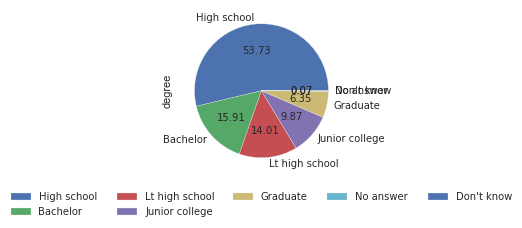

In [507]:
# population degree
simple_pie(df.degree,(3,3))

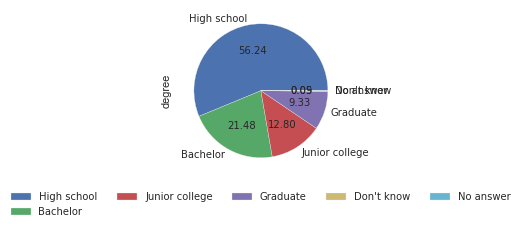

In [508]:
# cluster 0 degree
simple_pie(df_c0.degree,(3,3))

## Women in cluster 2 have the following characteratics:

  * Median family incomes are about the population median
  * They have high degrees (at least high school) **main driver**
  * Husbands also work full time, 42 hrs/wk
  * They don't have strong affiliation to religions.
  * Their median age of having first children is later than the population. 
  * They consider themselves working or middle class
  
  ## summary: having higher education degree, having kids late

## Cluster 3

In [518]:
c3 = fc_df[fc_df.cluster ==3]

In [519]:
sort_feature_means(c3,10)

[(-0.047762039104025079, 'coninc'),
 (0.030098106242422738, 'degree'),
 (0.013892893577860029, 'age'),
 (0.011935504426411342, 'educom'),
 (0.0093276884605862746, 'agekdbrn'),
 (0.0085354185432496652, 'partyid'),
 (0.0084588006421188345, 'class_'),
 (0.0077407653275778183, 'marital'),
 (0.0075419990811757525, 'dwelling'),
 (0.0072906876098014989, 'divorce')]

In [521]:
df_c3 = df[df.cluster==3]

In [520]:
df_summary[redu_heat_df.index].ix[3]

sphrs1                        40
chldidel                       2
age                           33
agekdbrn                      21
coninc                   9033.75
educom                     12.28
affrmact    Strongly oppose pref
fechld                     Agree
mobile16               Same city
natrace              About right
natspac                 Too much
reliten                   Strong
natfare                 Too much
divlaw            More difficult
partyid              Independent
finrela                  Average
helpoth            3rd important
degree               High school
socfrend        Sev times a week
fund                    Moderate
workhard           2nd important
marital            Never married
kidssol              Much better
class_             Working class
parsol           Somewhat better
employed                    True
Name: 3, dtype: object

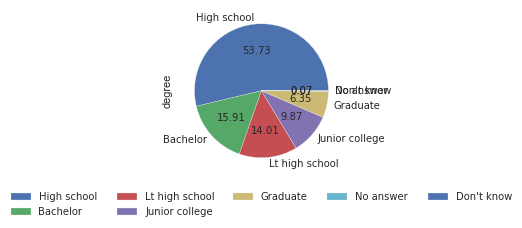

In [522]:
# population degree
simple_pie(df.degree,(3,3))

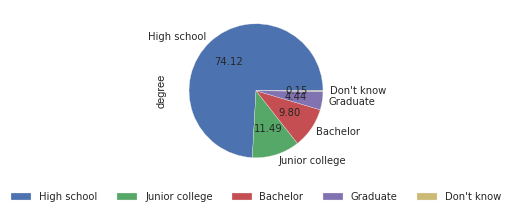

In [523]:
# cluster 3 degree
simple_pie(df_c3.degree,(3,3))

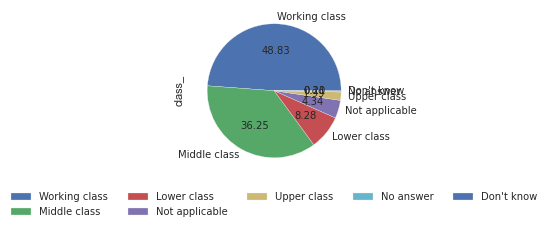

In [527]:
## population class
simple_pie(df.class_,(3,3))

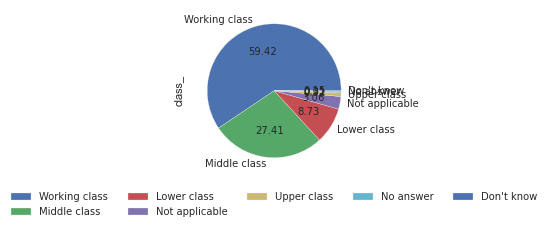

In [528]:
simple_pie(df_c3.class_,(3,3))

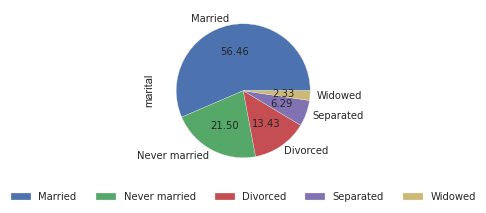

In [529]:
# Marital
simple_pie(df.marital,(3,3))

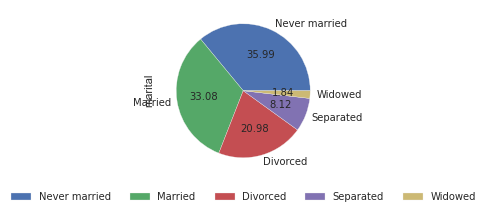

In [530]:
simple_pie(df_c3.marital,(3,3))

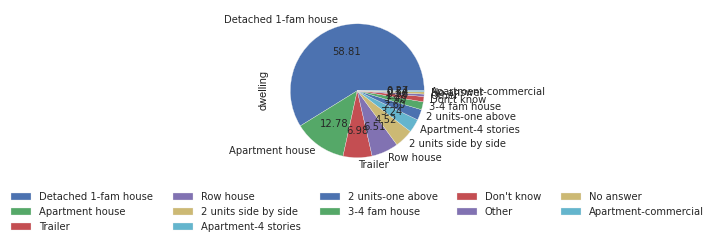

In [535]:
# Dwelling
simple_pie(df.dwelling,(3,3))

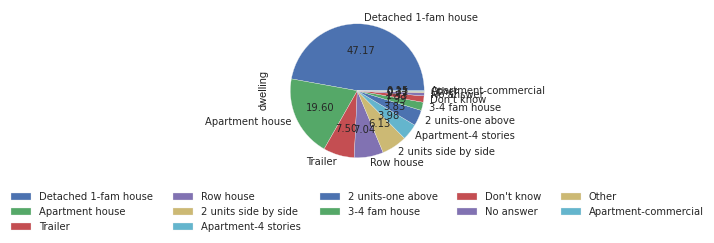

In [536]:
simple_pie(df_c3.dwelling,(3,3))

### Women in cluster 3 have following characteristics:
  * Family income way below population. They consider their finicial situation below average.
  * They have at least high school degree. and most of them with high school degree.
  * more of them consider themselves working class
  * Most of them are Never married or divorced. ** they are single moms. Main difference**
  * Moderate to conservative political views and strong affiliation to religions.
  
 ## summary: well educated, single moms. working class
  

## Cluster 4

In [541]:
c4 = fc_df[fc_df.cluster ==4]

In [542]:
sort_feature_means(c4,10)

[(-0.112494637432098, 'degree'),
 (0.023824348249125188, 'coninc'),
 (0.019713158066941121, 'age'),
 (0.012102558777930487, 'educom'),
 (0.011566590279362654, 'dwelling'),
 (0.011441392099877318, 'agekdbrn'),
 (0.010129008147363151, 'incom16'),
 (0.010116250691920407, 'polviews'),
 (0.010062968834124908, 'partyid'),
 (0.0095081045009339886, 'res16')]

In [543]:
df_c4 = df[df.cluster ==4]

In [544]:
df_summary[redu_heat_df.index].ix[4]

sphrs1                        40
chldidel                       3
age                           34
agekdbrn                      19
coninc                     18745
educom                     10.44
affrmact    Strongly oppose pref
fechld            Strongly agree
mobile16               Same city
natrace              About right
natspac                 Too much
reliten          Not very strong
natfare              About right
divlaw                    Easier
partyid              Independent
finrela                  Average
helpoth            3rd important
degree            Lt high school
socfrend            Once a month
fund                    Moderate
workhard           3rd important
marital                  Married
kidssol              Much better
class_             Working class
parsol               Much better
employed                    True
Name: 4, dtype: object

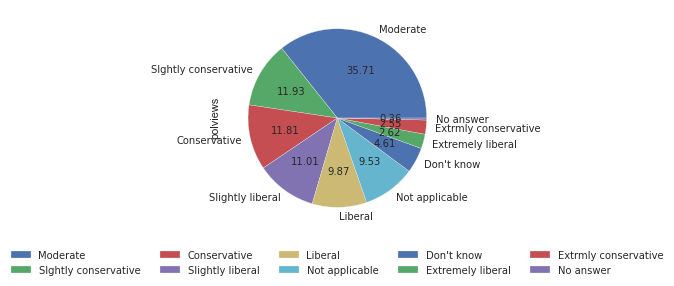

In [549]:
#dwelling
simple_pie(df.polviews,(4,4))

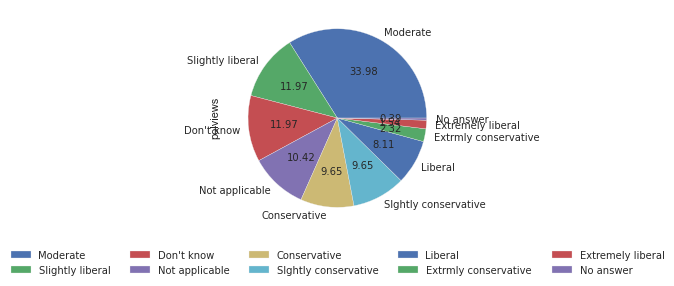

In [550]:
simple_pie(df_c4.polviews,(4,4))

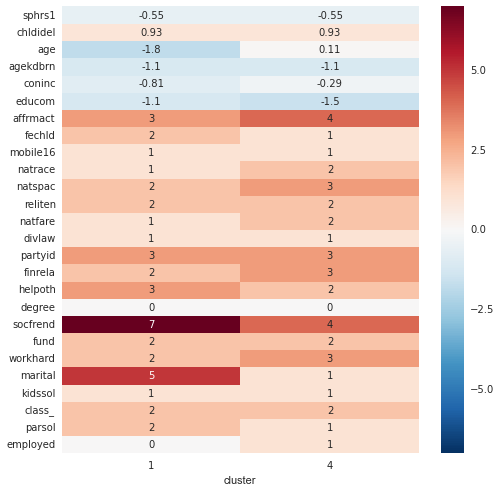

In [554]:
plt.figure(figsize=(8,8))
sns.heatmap(redu_heat_df[[1,4]],annot=True)

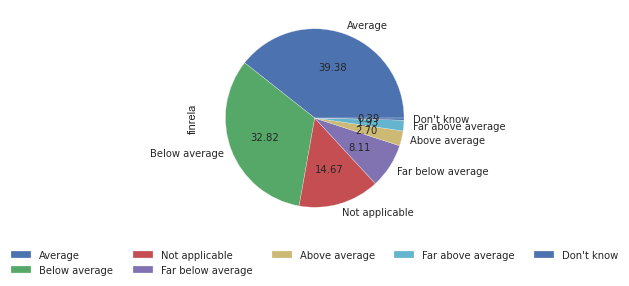

In [562]:
simple_pie(df_c4.finrela,(4,4))

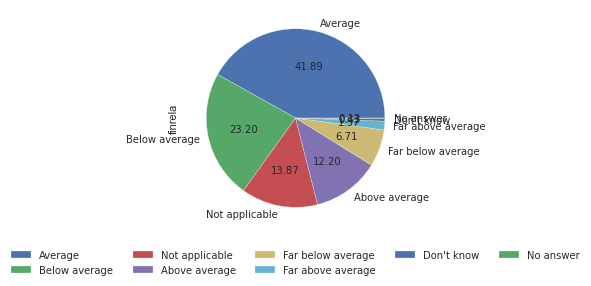

In [564]:
simple_pie(df.finrela,(4,4))

## Women in cluster 4 have following characterastics:
  * Have first kid early
  * Family has less eudcation than generage population
  * Don't have strong affiliation to religions
  * Moderate or have no interest in political views.
  * Less than high school degree
  * Low family income and consider their family income is below avereage
  ## Summary: Women in this cluster share lots of common with women in cluster 1, but they work. And maybe for the sake of they work, they sometimes spend evenings with friends.
  ## They strongly oppose to favor in hiring blacks to get rid of decriminations. And they think government spend too much on space exploration program. So they are more practical. 


## To do:

1. write a function to compare the cosine similarities among clusters. Compare the similar cluster, one emp, one unemp. and see what makes them different. 
2. Use data visualization tools to visualize the main decision drivers for each cluster.
3. Structuring some code.